In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import create_engine, inspect
from pathlib import Path

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
stations = Base.classes.station
measurements = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(measurements.date).order_by(measurements.date.desc()).first()

('2017-08-23',)

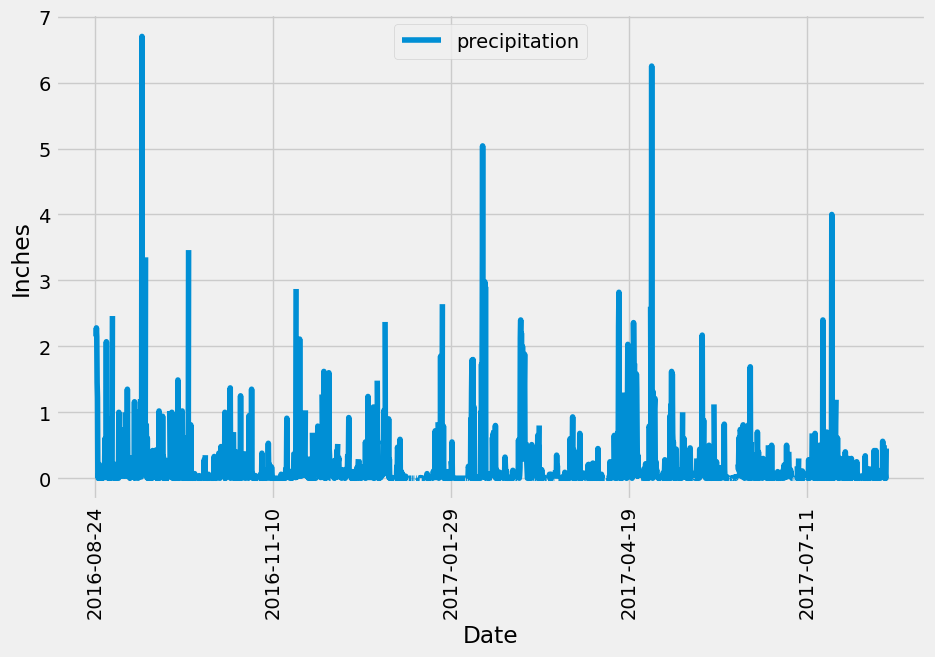

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.
most_recent = engine.execute("SELECT MAX(date) FROM measurement").fetchone()[0]

# Calculate the date one year from the last date in data set.
one_year = pd.to_datetime(most_recent) - pd.DateOffset(years=1)

# Perform a query to retrieve the data and precipitation scores
prcp_data = engine.execute(f"SELECT date, prcp FROM measurement WHERE date >= '{one_year}'").fetchall()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
hawaii_df = pd.DataFrame(prcp_data, columns=["date", "precipitation"])

# Sort the dataframe by date
hawaii_sorted_df = hawaii_df.sort_values(by="date")
hawaii_sorted_df.set_index("date", inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
hawaii_sorted_df.plot(figsize=(10, 6), rot=90)
plt.xlabel("Date")
plt.ylabel("Inches")
plt.legend(loc="upper center")
plt.show()

In [11]:
# Use Pandas to calculate the summary statistics for the precipitation data
hawaii_sorted_df.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [12]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(measurements.station).distinct().count()
total_stations

9

In [13]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(measurements.station, func.count(measurements.station)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [14]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
temp = session.query(func.min(measurements.tobs), func.max(measurements.tobs), func.avg(measurements.tobs)).\
    group_by(measurements.station).\
    order_by(func.count(measurements.station).desc()).first()
temp

(54.0, 85.0, 71.66378066378067)

In [15]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
active_station = session.query(measurements.tobs).\
    filter(measurements.station == 'USC00519281').\
    filter(measurements.date >= '2016-09-01').all()
    #group_by(measurements.tobs).all()
    #order_by(measurements.date).all()
#active_station

df = pd.DataFrame(active_station)

bins = [60, 65, 70, 75, 80, 85]
names = ["60", "65", "70", "75", "80"]

df["temp"] = pd.cut(df["tobs"], bins=bins, labels=names, include_lowest=True)


freq = df["temp"].value_counts()
#freq

#plt.hist(df["temp"])
#plt.xlabel("Temperature")
#plt.ylabel("Frequency")
#plt.legend(loc="upper right")
#plt.tight_layout
#plt.show()

df

,tobs,temp
0,80.0,75
1,80.0,75
2,78.0,75
3,78.0,75
4,78.0,75
...,...,...
338,77.0,75
339,77.0,75
340,76.0,75
341,76.0,75


# Close Session

In [16]:
# Close Session
session.close()